In [ ]:
!pip install segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
!pip install torchinfo

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from torchinfo import summary

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# We define a function to create a list of the paths of the images and masks.
def image_mask_path(image_path:str, mask_path:str):
    IMAGE_PATH = Path(image_path)
    IMAGE_PATH_LIST = sorted(list(IMAGE_PATH.glob("*.png")))

    MASK_PATH = Path(mask_path)
    MASK_PATH_LIST = sorted(list(MASK_PATH.glob("*.png")))

    return IMAGE_PATH_LIST, MASK_PATH_LIST

In [ ]:
image_path_train = "/content/drive/MyDrive/BCSS_512/train_512"
mask_path_train = "/content/drive/MyDrive/BCSS_512/train_mask_512"

IMAGE_PATH_LIST_TRAIN, MASK_PATH_LIST_TRAIN = image_mask_path(image_path_train,
                                                              mask_path_train)

print(f'Total Images Train: {len(IMAGE_PATH_LIST_TRAIN)}')
print(f'Total Masks Train: {len(MASK_PATH_LIST_TRAIN)}')

Total Images Train: 6000
Total Masks Train: 6000


In [ ]:
image_path_val = "/content/drive/MyDrive/BCSS_512/val_512"
mask_path_val = "/content/drive/MyDrive/BCSS_512/val_mask_512"

IMAGE_PATH_LIST_VAL, MASK_PATH_LIST_VAL = image_mask_path(image_path_val,
                                                          mask_path_val)

print(f'Total Images Val: {len(IMAGE_PATH_LIST_VAL)}')
print(f'Total Masks Val: {len(MASK_PATH_LIST_VAL)}')

Total Images Val: 2768
Total Masks Val: 2768


In [ ]:
VALUES_UNIQUE_TRAIN = []

for i in MASK_PATH_LIST_TRAIN:
    sample = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    uniques = np.unique(sample)
    VALUES_UNIQUE_TRAIN.append(uniques)

FINAL_VALUES_UNIQUE_TRAIN = np.concatenate(VALUES_UNIQUE_TRAIN)
print("Unique values Train:\n")
print(np.unique(FINAL_VALUES_UNIQUE_TRAIN))

Unique values Train:

[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20]


In [ ]:
VALUES_UNIQUE_VAL = []

for i in MASK_PATH_LIST_VAL:
    sample = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    uniques = np.unique(sample)
    VALUES_UNIQUE_VAL.append(uniques)

FINAL_VALUES_UNIQUE_VAL = np.concatenate(VALUES_UNIQUE_VAL)
print("Unique values Validation:\n")
print(np.unique(FINAL_VALUES_UNIQUE_VAL))

Unique values Validation:

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19]


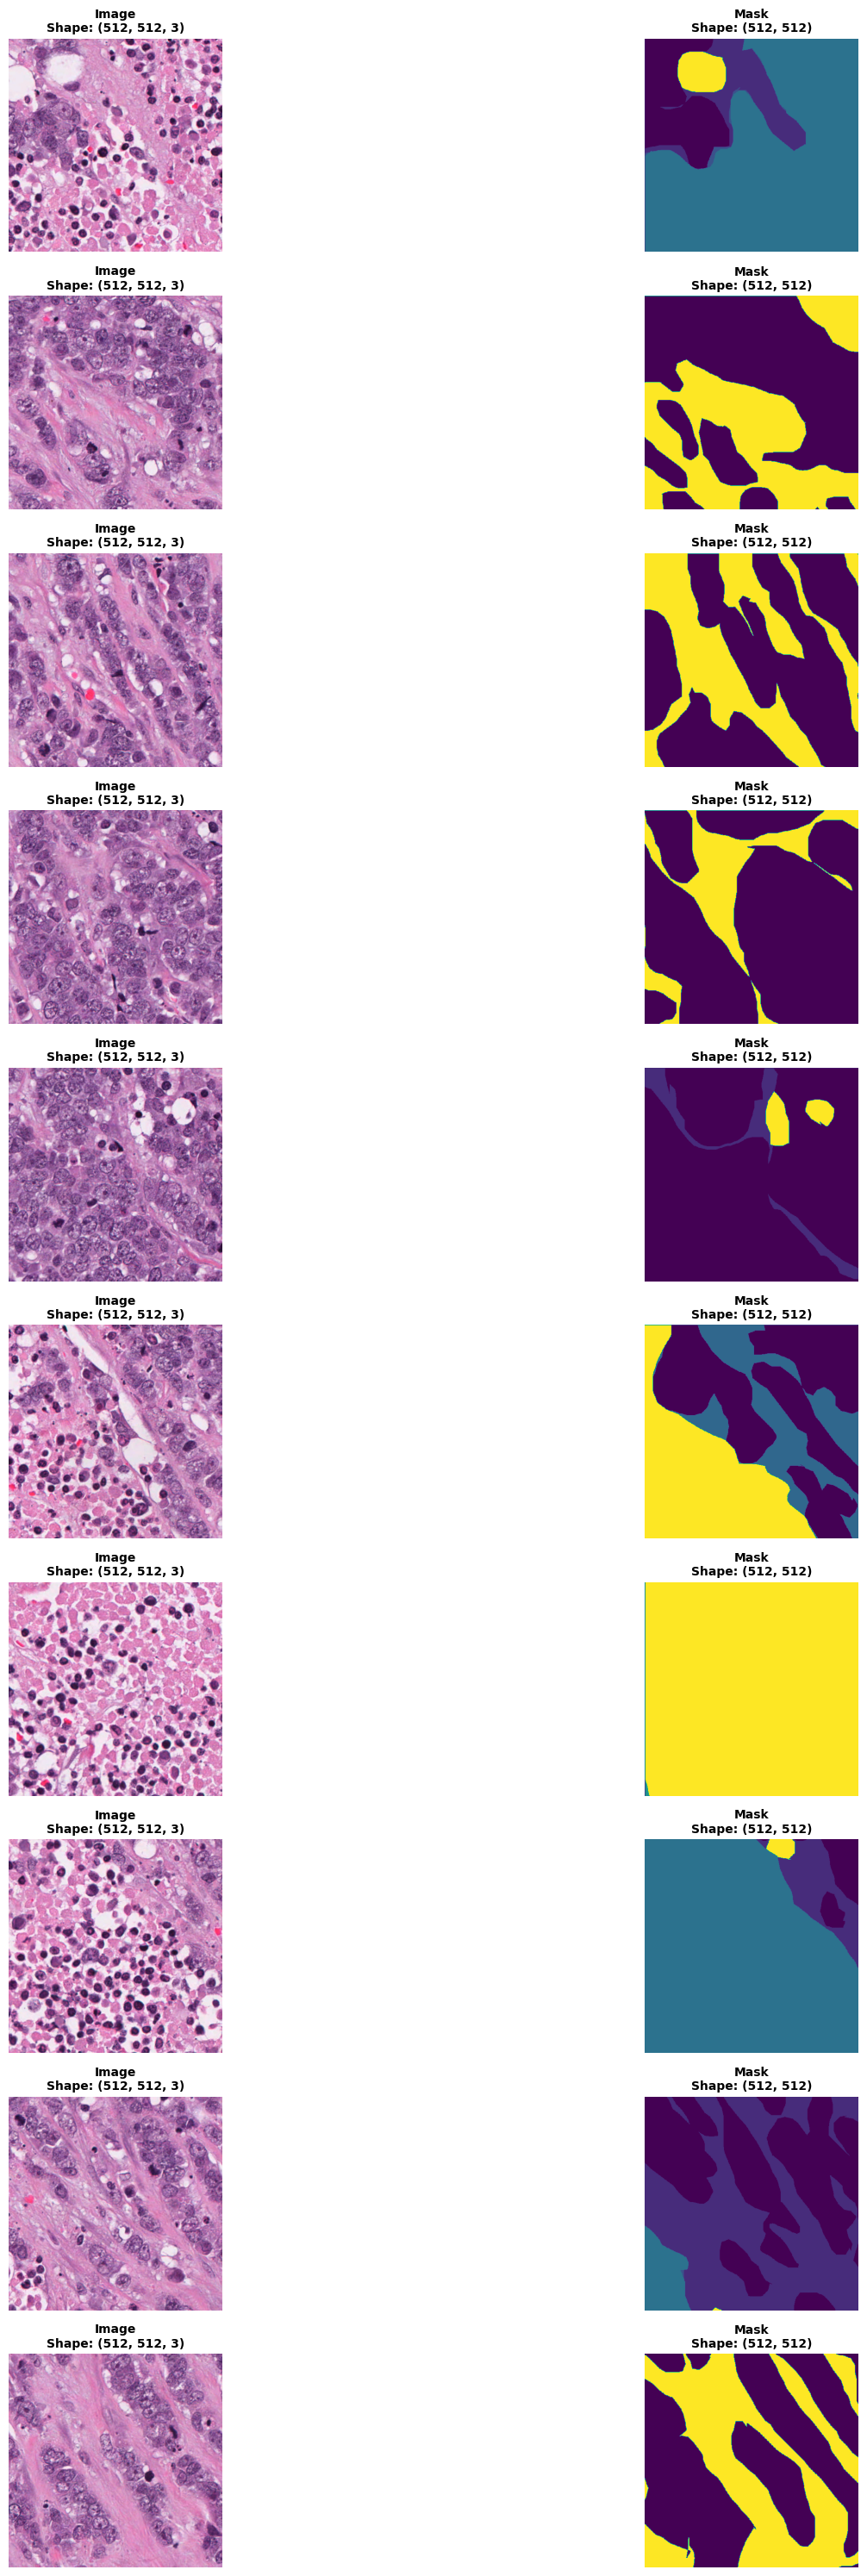

In [ ]:
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (20,30))

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST_TRAIN, MASK_PATH_LIST_TRAIN)):

    if i>9:
        break

    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(img_rgb)
    ax[i,0].axis('off')
    ax[i,0].set_title(f"Image\nShape: {img_rgb.shape}", fontsize = 10, fontweight = "bold", color = "black")

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    ax[i,1].imshow(mask)
    ax[i,1].axis('off')
    ax[i,1].set_title(f"Mask\nShape: {mask.shape}", fontsize = 10, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

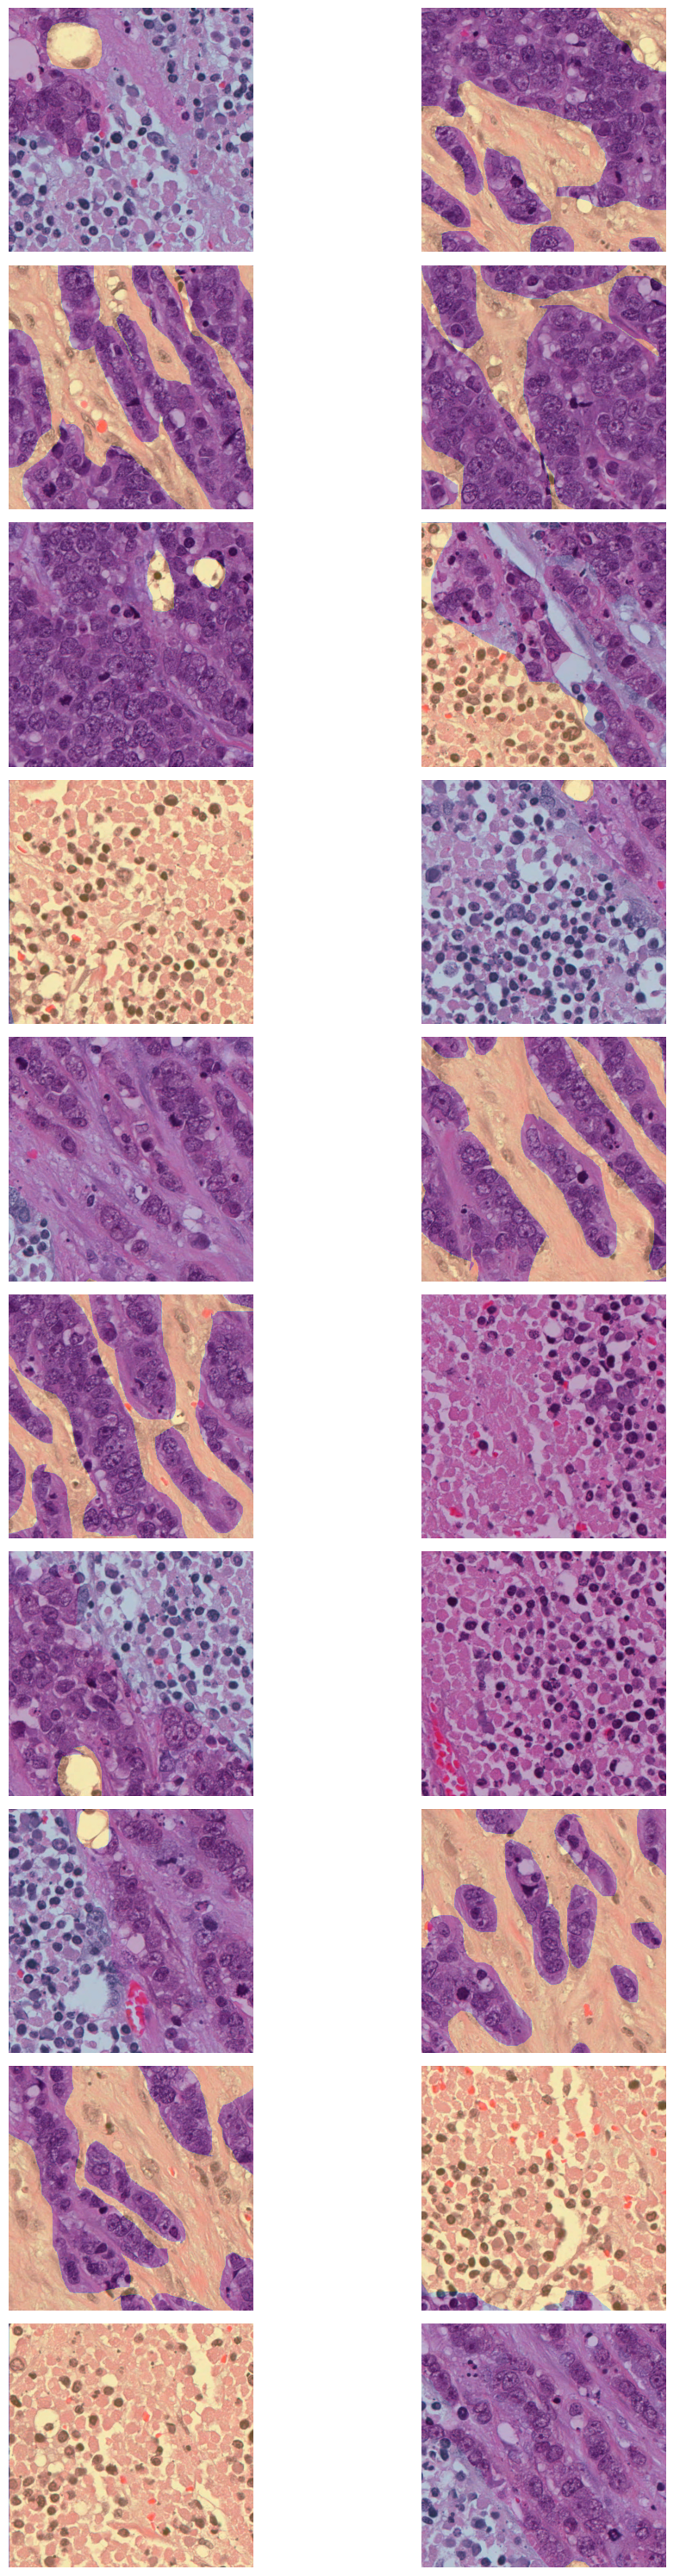

In [ ]:
# We visualize some images but with the mask superimposed.
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (12,30))
ax = ax.flat

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST_TRAIN, MASK_PATH_LIST_TRAIN)):

    if i>19:
        break

    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_rgb)
    ax[i].axis('off')


    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    ax[i].imshow(mask, alpha = 0.30)
    ax[i].axis('off')


fig.tight_layout()
fig.show()

In [ ]:
data_train = pd.DataFrame({'Image':IMAGE_PATH_LIST_TRAIN,
                           'Mask':MASK_PATH_LIST_TRAIN})

data_val = pd.DataFrame({'Image':IMAGE_PATH_LIST_VAL,
                         'Mask':MASK_PATH_LIST_VAL})

In [ ]:
preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name = "resnet34",
                                        pretrained = "imagenet")
preprocess_input

functools.partial(<function preprocess_input at 0x7e5d02ca0d30>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
RESIZE = (224, 224)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([transforms.Resize(RESIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = MEAN, std = STD)])

mask_transforms = transforms.Compose([transforms.Resize(RESIZE),
                                      transforms.PILToTensor()])

In [ ]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, data:pd.DataFrame, image_transforms, mask_transforms):
        self.data = data
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)

        mask_path = self.data.iloc[idx, 1]
        mask = Image.open(mask_path)
        mask = self.mask_transforms(mask)

        return image, mask

In [ ]:
train_dataset = CustomImageMaskDataset(data_train, image_transforms,
                                       mask_transforms)

val_dataset = CustomImageMaskDataset(data_val, image_transforms,
                                     mask_transforms)

In [ ]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE,
                            shuffle = True, num_workers = NUM_WORKERS)

In [ ]:
# We visualize the dimensions of a batch.
batch_images, batch_masks = next(iter(train_dataloader))

batch_images.shape, batch_masks.shape

In [ ]:
# CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

In [ ]:
# Define model
model = smp.Unet(in_channels = 3, classes = 21)

In [ ]:
summary(model = model,
        input_size = [64, 3, 224, 224],
        col_width = 15,
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings = ['var_names'])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

In [ ]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    train_accuracy = 0.

    for batch, (X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)
        optimizer.zero_grad()
        logit_mask = model(X)
        loss = loss_fn(logit_mask, y.squeeze())
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        prob_mask = logit_mask.softmax(dim = 1)
        pred_mask = prob_mask.argmax(dim = 1)

        tp,fp,fn,tn = smp.metrics.get_stats(output = pred_mask.detach().cpu().long(),
                                            target = y.squeeze().cpu().long(),
                                            mode = "multiclass",
                                            num_classes = 21)

        train_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction = "micro").numpy()

    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)

    return train_loss, train_accuracy

In [ ]:
def val_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module):

    model.eval()

    val_loss = 0.
    val_accuracy = 0.

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)
            logit_mask = model(X)
            loss = loss_fn(logit_mask, y.squeeze())
            val_loss += loss.item()

            prob_mask = logit_mask.softmax(dim = 1)
            pred_mask = prob_mask.argmax(dim = 1)

            tp, fp, fn, tn = smp.metrics.get_stats(output = pred_mask.detach().cpu().long(),
                                                   target = y.squeeze().cpu().long(),
                                                   mode = "multiclass",
                                                   num_classes = 21)

            val_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction = "micro").numpy()

    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)

    return val_loss, val_accuracy

In [ ]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader,
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer, early_stopping, epochs:int = 10):

    results = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        val_loss, val_accuracy = val_step(model = model,
                                     dataloader = val_dataloader,
                                     loss_fn = loss_fn)

        print(f'Epoch: {epoch + 1} | ',
              f'Train Loss: {train_loss:.4f} | ',
              f'Train Accuracy: {train_accuracy:.4f} | ',
              f'Val Loss: {val_loss:.4f} | ',
              f'Val Accuracy: {val_accuracy:.4f}')

        early_stopping(val_loss, model)

        if early_stopping.early_stop == True:
            print("Early Stopping!!!")
            break

        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['val_loss'].append(val_loss)
        results['val_accuracy'].append(val_accuracy)

    return results

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)

In [ ]:
SEED = 42
EPOCHS = 70
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE),
                train_dataloader,
                val_dataloader,
                loss_fn,
                optimizer,
                early_stopping,
                EPOCHS)

In [ ]:
def loss_and_metric_plot(results:dict):

    training_loss = results['train_loss']
    training_metric = results['train_accuracy']

    validation_loss = results['val_loss']
    validation_metric = results['val_accuracy']

    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3.8))
    ax = ax.flat

    ax[0].plot(training_loss, label = "Train")
    ax[0].plot(validation_loss, label = "Val")
    ax[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    ax[0].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[0].set_ylabel("loss", fontsize = 10, fontweight = "bold", color = "black")

    ax[1].plot(training_metric, label = "Train")
    ax[1].plot(validation_metric, label = "Val")
    ax[1].set_title("Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    ax[1].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[1].set_ylabel("score", fontsize = 10, fontweight = "bold", color = "black")

    fig.tight_layout()
    fig.show()

In [ ]:
loss_and_metric_plot(RESULTS)

In [ ]:
def predictions_mask(test_dataloader:torch.utils.data.DataLoader):

    checkpoint = torch.load("/kaggle/working/best_model.pth")

    loaded_model = smp.Unet(encoder_weights = None, classes = 21)

    loaded_model.load_state_dict(checkpoint)

    loaded_model.to(device = DEVICE)

    loaded_model.eval()

    y_pred_mask = []

    with torch.inference_mode():
        for batch,X in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
            X = X.to(device = DEVICE, dtype = torch.float32)
            mask_logit = loaded_model(X)
            mask_prob = mask_logit.softmax(dim = 1)
            mask_pred = mask_prob.argmax(dim = 1)
            y_pred_mask.append(mask_pred.detach().cpu())

    y_pred_mask = torch.cat(y_pred_mask)

    return y_pred_mask

In [ ]:
image_path_test = "/kaggle/input/breast-cancer-semantic-segmentation-bcss/BCSS/test"

IMAGE_PATH_LIST_TEST = list(Path(image_path_test).glob("*.png"))

print(f'Total Images Train: {len(IMAGE_PATH_LIST_TEST)}')

In [ ]:
data_test = pd.DataFrame({'Image':IMAGE_PATH_LIST_TEST})
data_test.head()

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, data:pd.DataFrame, image_transforms):
        self.data = data
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)

        return image

In [ ]:
# Dataset
test_dataset = CustomTestDataset(data_test, image_transforms)

# DataLoader
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
# We execute the predictions!!
y_pred_mask = predictions_mask(test_dataloader)

In [ ]:
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (12,35))

for index, row in data_test.iterrows():
    if index > 9:
        break

    img_bgr = cv2.imread(str(row[0]))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[index, 0].imshow(img_rgb)
    ax[index, 0].axis('off')
    ax[index, 0].set_title("Image", fontsize = 12, fontweight = "bold", color = "black")

    ax[index, 1].imshow(y_pred_mask[index].squeeze().numpy())
    ax[index, 1].axis('off')
    ax[index, 1].set_title("Mask", fontsize = 12, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()